In [12]:
#Zip Datei entpacken
import zipfile
import os
import tifffile
import glob

# Path to our Zip file with the training data
current_dir = os.getcwd()
zip_path = os.path.join(current_dir, "MoNuSAC_images_and_annotations.zip")

# Paths to the data and the masks
extract_dir_data = "data"
extract_dir_masks  = "MoNuSAC_masks" #load masks instead of datasets (generatet via binary_mask_generation)

# Ordner erstellen, falls nicht vorhanden
#os.makedirs(extract_dir_data, exist_ok=True)

# ZIP entpacken
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_dir_data)

# Get the tif files
tif_files_data = glob.glob(os.path.join(extract_dir_data,"**", "*.tif"), recursive=True)
print(f"Found TIFF-data: {len(tif_files_data)}")

tif_files_masks = glob.glob(os.path.join(extract_dir_masks,"**", "*.tif"), recursive=True)
print(f"Found TIFF-Masks: {len(tif_files_masks)}")

Found TIFF-data: 209
Found TIFF-Masks: 394


Loaded number of data images: 209


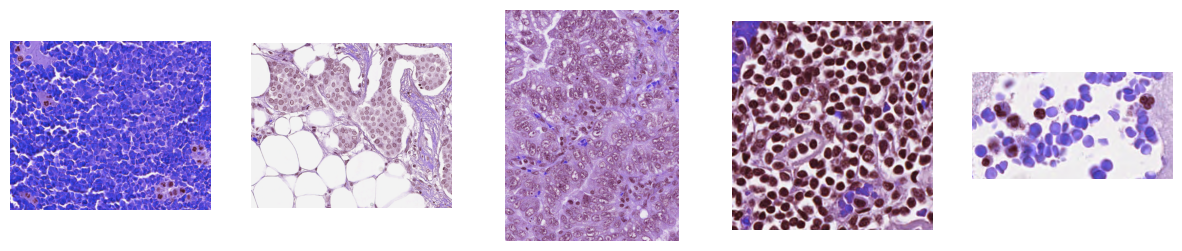

In [13]:
import matplotlib.pyplot as plt
import random

images_original = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files_data if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_original.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Loaded number of data images:", len(images_original))

if len(images_original) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_original))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_original[random.randint(0, len(images_original))]) # getting random images
        plt.axis("off")
    plt.show()

Loaded number of masks images: 394


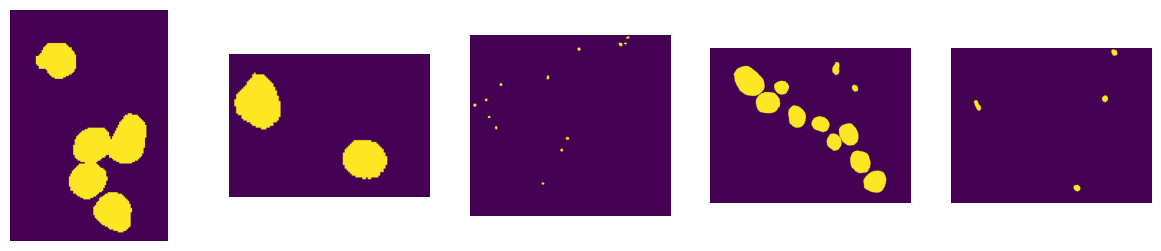

In [14]:
import matplotlib.pyplot as plt

images_masks = []
# Ensure we only try to load valid files
valid_files = [f for f in tif_files_masks if f.endswith(('.tif', '.tiff'))]

for f in valid_files:
    try:
        # tifffile returns a numpy array directly
        img = tifffile.imread(f)
        images_masks.append(img)
    except Exception as e:
        print(f"Error loading {f}: {e}")

print("Loaded number of masks images:", len(images_masks))

if len(images_masks) > 0:
    plt.figure(figsize=(15,3))
    # Limit to 5 or the length of images, whichever is smaller
    count = min(5, len(images_masks))
    
    for i in range(count):
        plt.subplot(1, 5, i+1)
        plt.imshow(images_masks[random.randint(0, len(images_masks))])
        plt.axis("off")
    plt.show()

In [ ]:
import torch
from sklearn.model_selection import train_test_split


# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training läuft auf: {device}")

# Parameter
IMG_SIZE = 256  # scale pictures
BATCH_SIZE = 8  # how many pictures we look at the same time
LEARNING_RATE = 1e-4 # size of steps to min error
EPOCHS = 100 # how many times we look at every picture in our set

Training läuft auf: cuda


In [16]:
import os
import glob
import numpy as np
import tifffile
import torch
import random
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.transforms.v2 as v2
from sklearn.model_selection import train_test_split
import torchvision.transforms.v2 as v2

all_files = [f for f in tif_files_data if f.endswith(('.tif', '.tiff'))]
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

class MoNuSACDataset(Dataset):
    def __init__(self, image_paths, mask_base_dir, transform=None, augment=False):
        self.image_paths = image_paths
        self.mask_base_dir = mask_base_dir
        self.transform = transform
        self.augment = augment
        self.IMG_SIZE = IMG_SIZE
        self.elastic = v2.ElasticTransform(alpha=50.0, sigma=5.0)
        
        self.class_map = {
            "Epithelial": 1, "Lymphocyte": 2, "Macrophage": 3, "Neutrophil": 4
        }
        
        self.full_mask_index = {}
        
        all_mask_tifs = glob.glob(os.path.join(mask_base_dir, "**", "*.tif"), recursive=True)
        
        for path in all_mask_tifs:
            parts = path.split(os.sep)
            if len(parts) >= 3:
                img_name = parts[-3]
                cell_type = parts[-2]
                
                if img_name not in self.full_mask_index:
                    self.full_mask_index[img_name] = {}
                self.full_mask_index[img_name][cell_type] = path

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        # load images
        img_path = self.image_paths[idx]
        image = tifffile.imread(img_path)
        base_name = os.path.splitext(os.path.basename(img_path))[0]

        filename = os.path.basename(img_path)
        
        image_mask_dict = self.full_mask_index.get(base_name, {})
        
        h, w = image.shape[:2]
        mask = np.zeros((h, w), dtype=np.int64) 
        
        # Masken-Layer zusammenfügen
        for cell_type, class_idx in self.class_map.items():
            filepath = image_mask_dict.get(cell_type)
            if filepath:
                try:
                    layer = tifffile.imread(filepath)
                    mask[layer > 0] = class_idx
                except:
                    pass
        
        # convert to PIL
        image_pil = Image.fromarray(image).convert("RGB")
        mask_pil = Image.fromarray(mask.astype(np.uint8))
        
        # Resize
        #image_pil = image_pil.resize((self.IMG_SIZE, self.IMG_SIZE))
        #mask_pil = mask_pil.resize((self.IMG_SIZE, self.IMG_SIZE), resample=Image.NEAREST)
        
        # data augmentaion randomly 50% chance
        if self.augment:

            cropper = v2.RandomCrop(size=(self.IMG_SIZE, self.IMG_SIZE), pad_if_needed=True, fill=0)
            image_pil, mask_pil = cropper(image_pil, mask_pil)


            if random.random() > 0.5:
                image_pil = TF.hflip(image_pil)
                mask_pil = TF.hflip(mask_pil)

            if random.random() > 0.5:
                image_pil = TF.vflip(image_pil)
                mask_pil = TF.vflip(mask_pil)

            # Transponieren (X und Y Achse tauschen)
            if random.random() > 0.5:
                image_pil = image_pil.transpose(Image.TRANSPOSE)
                mask_pil = mask_pil.transpose(Image.TRANSPOSE)

            # Elastische Deformation
            if random.random() > 0.2:
                # Wir nutzen einen festen Seed, damit Bild & Maske gleich deformiert werden
                state = torch.get_rng_state()
                image_pil = self.elastic(image_pil)
                torch.set_rng_state(state)
                mask_pil = self.elastic(mask_pil)
        else:
            # Wir füllen die Ränder mit Schwarz auf, bis die Maße durch 32 teilbar sind Nur in Validierung
            w, h = image_pil.size
            new_w = (w // 32 + 1) * 32 if w % 32 != 0 else w
            new_h = (h // 32 + 1) * 32 if h % 32 != 0 else h
            
            # Padder fügt rechts und unten einfach schwarze Pixel hinzu
            padder = v2.Pad((0, 0, new_w - w, new_h - h), fill=0)
            image_pil, mask_pil = padder(image_pil, mask_pil)

        # to Tensor
        img_tensor = transforms.ToTensor()(image_pil)
        mask_array = np.array(mask_pil, dtype=np.int64)
        mask_tensor = torch.from_numpy(mask_array)
        
        return img_tensor, mask_tensor, filename

# create the dataset
extract_dir_masks = "MoNuSAC_masks" 

# augment=True only in training
train_dataset = MoNuSACDataset(train_files, extract_dir_masks, augment=True)
val_dataset = MoNuSACDataset(val_files, extract_dir_masks, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) #Batch size 1 für validierung

print("Augmentation aktiviert für Training-Set.")

Augmentation aktiviert für Training-Set.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


"""
FPN hat 3 Pfade:
Der Bottom-up Pathway dies ist das normale cnn es extrahiert unsere features und macht das bild kleiner
Der Top-Down Pathway hier nimmt das FPN die tiefsten (schlausten) Features und macht ein upsamling auf diesen
und die Querverbindungen (lateral connections) wo das FPN die genauen räumlichen featurs aus den frühere schichten des cnns nimmt und
addiert sie zu den vergrößerten semantischen features aus dem Top-Down pathway
"""
class ResNetFPN(nn.Module):
    def __init__(self, n_classes=5, fpn_channels=256): #5 klassen und die anzahl der kanäle unsere pyramide
        super().__init__()
        
        # 1. Encoder (ResNet50 Backbone)
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
        # Layer 0: Initiale Faltungen vor den eigentlichen ResNet-Blöcken (1/4 Auflösung)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        
        # Die ResNet Blöcke (C1 bis C4) wobei jeder block die auflösung halbiert und die anzahl der kanäle verdoppelt
        self.layer1 = resnet.layer1  # Output: 256 Channels  (1/4 Auflösung)
        self.layer2 = resnet.layer2  # Output: 512 Channels  (1/8 Auflösung)
        self.layer3 = resnet.layer3  # Output: 1024 Channels (1/16 Auflösung)
        self.layer4 = resnet.layer4  # Output: 2048 Channels (1/32 Auflösung)
        
        # 2. Laterale Verbindungen (1x1 Convs, um alles auf z.B. 256 Channels zu bringen)
        self.lat_layer1 = nn.Conv2d(256, fpn_channels, kernel_size=1)
        self.lat_layer2 = nn.Conv2d(512, fpn_channels, kernel_size=1)
        self.lat_layer3 = nn.Conv2d(1024, fpn_channels, kernel_size=1)
        self.lat_layer4 = nn.Conv2d(2048, fpn_channels, kernel_size=1)
        
        # 3. Smoothing Layers (3x3 Convs, um Aliasing-Effekte nach der Addition zu glätten) da bei der addition kantenartefakte entstehen (könnten)
        self.smooth_layer1 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        self.smooth_layer2 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        self.smooth_layer3 = nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1)
        
        # 4. Finaler Segmentierungs-Kopf, nimmt die feature map und wandelt die kanäle in die gewünschte anzahl der klassen um
        self.final_conv = nn.Sequential(
            nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(fpn_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(fpn_channels, n_classes, kernel_size=1)
        )

    #hilfsfunktion für vergrößeren und kombinieren
    def _upsample_add(self, x, y):
        """Hilfsfunktion: Skaliert x auf die Größe von y hoch und addiert beide."""
        _, _, H, W = y.size()
        upsampled_x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=False)
        return upsampled_x + y

    #forward pass wo das bild(tensor) durch das netzwerk fleißt/geschickt wird
    def forward(self, x):
        input_shape = x.shape[2:] # Merken uns die Originalgröße (H, W)
        
        # --- Bottom-Up Pathway (Encoder) ---
        c0 = self.layer0(x)
        c1 = self.layer1(c0)
        c2 = self.layer2(c1)
        c3 = self.layer3(c2)
        c4 = self.layer4(c3)
        
        # --- Top-Down Pathway & Lateral Connections (Die Pyramide) ---
        # Ebene 4 (ganz unten im Netz, tiefste Features)
        p4 = self.lat_layer4(c4)
        
        # Ebene 3
        p3 = self._upsample_add(p4, self.lat_layer3(c3))
        p3 = self.smooth_layer3(p3)
        
        # Ebene 2
        p2 = self._upsample_add(p3, self.lat_layer2(c2))
        p2 = self.smooth_layer2(p2)
        
        # Ebene 1
        p1 = self._upsample_add(p2, self.lat_layer1(c1))
        p1 = self.smooth_layer1(p1)
        
        # Wir nehmen die höchste Pyramidenebene (p1) für die Segmentierung
        out = self.final_conv(p1)
        
        # Da p1 nur 1/4 der Originalauflösung hat, skalieren wir den Output ganz am Ende 
        # auf die ursprüngliche Bildgröße hoch (z.B. von 64x64 zurück auf 256x256)
        out = F.interpolate(out, size=input_shape, mode='bilinear', align_corners=False)
        
        return out

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#should work better with medical  pictures beacuse it will ignore the background. Crossentropy loss doesn't do this.
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs: [Batch, Classes, H, W] (Logits vom U-Net)
        # targets: [Batch, H, W] (Indices 0-4)
        
        # 1. Softmax auf die Inputs anwenden, um Wahrscheinlichkeiten zu bekommen
        inputs = F.softmax(inputs, dim=1)
        
        # 2. Targets in One-Hot-Encoding umwandeln
        # Von [B, H, W] zu [B, H, W, C]
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1])
        
        # Dimensionen tauschen zu [B, C, H, W] damit es zu den inputs passt
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()
        
        # 3. Dice Score berechnen
        # Intersection: Elementweise Multiplikation und Summe über H und W
        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        
        # Union: Summe der Inputs + Summe der Targets
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        # Dice Formel: 2*Inter / (Union + smooth)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Durchschnitt über alle Klassen im Batch nehmen
        # 1 - Dice, da wir minimieren wollen (Dice=1 ist perfekt, Loss=0 ist perfekt)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice = DiceLoss()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice

    def forward(self, inputs, targets):
        loss_ce = self.ce(inputs, targets)
        loss_dice = self.dice(inputs, targets)
        
        # Man kann hier auch gewichten, z.B. 0.5 * ce + 0.5 * dice
        # Aber einfache Addition funktioniert meist super.
        return (self.weight_ce * loss_ce) + (self.weight_dice * loss_dice)
    

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        # alpha ist gewichts vektor
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Standard Cross Entropy berechnen (aber nicht reduzieren, wir brauchen den Fehler pro Pixel)
        ce_loss_unweighted = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss_unweighted)
        # pt ist die Wahrscheinlichkeit, dass das Modell richtig lag

        # 2. Prüfen: Haben wir einen Gewichts-Tensor oder nur eine Zahl?
        if isinstance(self.alpha, torch.Tensor):
            # Wenn es ein Tensor ist, nutzt PyTorch ihn für die Klassen-Gewichtung
            ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        else:
            # Wenn es keine Gewichte gibt (oder nur eine Zahl), rechne normal
            ce_loss = ce_loss_unweighted
            if self.alpha is not None:
                ce_loss = ce_loss * self.alpha # Multipliziert alles gleichmäßig
                
        # 3. Focal Magie anwenden
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        return focal_loss.mean()
    
class CombinedFocalDiceLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_focal=1.0):
        super(CombinedFocalDiceLoss, self).__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss(gamma=2)
        
        self.weight_dice = weight_dice
        self.weight_focal = weight_focal

    def forward(self, inputs, targets):
        loss_dice = self.dice(inputs, targets)
        loss_focal = self.focal(inputs, targets)
        
        return (self.weight_dice * loss_dice) + (self.weight_focal * loss_focal)

def dice_coeff(preds, targets, num_classes=5, ignore_index=None, epsilon=1e-6):
    preds = torch.softmax(preds, dim=1)
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()
    
    dice_per_class = []
    # Startet bei 1, wenn der Hintergrund (0) ignoriert werden soll
    #start_class = 1 if ignore_index is not None else 0
    
    for class_id in range(0, num_classes):
        p = preds[:, class_id, ...].reshape(-1)
        t = targets_one_hot[:, class_id, ...].reshape(-1)
        
        intersection = (p * t).sum()
        union = p.sum() + t.sum()
        
        dice = (2. * intersection + epsilon) / (union + epsilon)
        dice_per_class.append(dice)
    
    return torch.stack(dice_per_class).mean()

In [19]:
import torch.optim.lr_scheduler as lr_scheduler

weights = torch.tensor([0.1, 1.0, 1.0, 1.1, 1.1]).to(device)
model = ResNetFPN(n_classes=5).to(device)
#criterion = CombinedLoss(weight_dice=0.5, weight_ce=0.5)
#criterion = DiceLoss()
#criterion = nn.CrossEntropyLoss()
criterion = CombinedFocalDiceLoss(weight_dice=0.3, weight_focal=0.7)
#criterion = FocalLoss(alpha=weights, gamma=2)
#criterion = FocalLoss(alpha=1, gamma=2)


# Listen zum Speichern der Historie
train_loss_history = []
val_loss_history = []   
val_dice_history = []

#optimizer = torch.optim.Adam([{'params': model.encoder.parameters(), 'lr': 0},{'params': model.decoder.parameters(), 'lr': LEARNING_RATE}])
optimizer = torch.optim.Adam([
    {'params': model.layer0.parameters(), 'lr': 1e-5},
    {'params': model.layer1.parameters(), 'lr': 1e-5},
    {'params': model.layer2.parameters(), 'lr': 1e-5},
    {'params': model.layer3.parameters(), 'lr': 1e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-5},
    {'params': model.lat_layer1.parameters(), 'lr': 1e-4}, # Neuer FPN-Teil
    {'params': model.final_conv.parameters(), 'lr': 1e-4}, # Neuer Head
], lr=1e-4)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("Starte Training...")

for epoch in range(EPOCHS):
    
    model.train()
    train_loss = 0
    
    for images, masks, _ in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Durchschnittlichen Loss für diese Epoche berechnen
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks, _ in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            batch_dice = dice_coeff(outputs, masks, num_classes=5, ignore_index=0)
            val_dice += batch_dice.item()
      
    # Durchschnittlichen Val-Loss berechnen
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_dice_history.append(avg_val_dice)
     
    print(f"Epoch [{epoch+1}/{EPOCHS}], "
      f"Train Loss: {avg_train_loss:.4f}, "
      f"Val Loss: {avg_val_loss:.4f}, "
      f"Val Dice Score: {avg_val_dice:.4f}")
    
    #scheduler.step()

    #nur zur kontrolle
    #lr_encoder = optimizer.param_groups[0]['lr']
    #lr_decoder = optimizer.param_groups[1]['lr']

print("Training beendet!")

Starte Training...
Epoch [1/100], Train Loss: 0.7190, Val Loss: 0.6582, Val Dice Score: 0.1451
Epoch [2/100], Train Loss: 0.5076, Val Loss: 0.4754, Val Dice Score: 0.1899
Epoch [3/100], Train Loss: 0.4190, Val Loss: 0.4504, Val Dice Score: 0.1991
Epoch [4/100], Train Loss: 0.3788, Val Loss: 0.4283, Val Dice Score: 0.2097
Epoch [5/100], Train Loss: 0.3581, Val Loss: 0.3874, Val Dice Score: 0.2195
Epoch [6/100], Train Loss: 0.3454, Val Loss: 0.4034, Val Dice Score: 0.2182
Epoch [7/100], Train Loss: 0.3354, Val Loss: 0.3504, Val Dice Score: 0.2382
Epoch [8/100], Train Loss: 0.3294, Val Loss: 0.3523, Val Dice Score: 0.2376
Epoch [9/100], Train Loss: 0.3237, Val Loss: 0.3515, Val Dice Score: 0.2400
Epoch [10/100], Train Loss: 0.3218, Val Loss: 0.3301, Val Dice Score: 0.2502
Epoch [11/100], Train Loss: 0.3143, Val Loss: 0.3508, Val Dice Score: 0.2438
Epoch [12/100], Train Loss: 0.3102, Val Loss: 0.3222, Val Dice Score: 0.2603
Epoch [13/100], Train Loss: 0.3061, Val Loss: 0.3359, Val Dice Sco

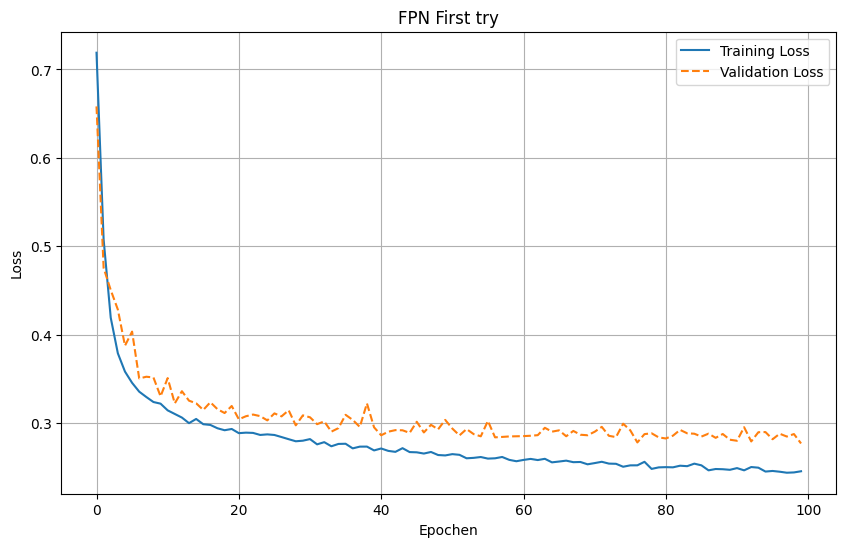

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')

plt.title('FPN First try')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Zeige zufällige Samples an den Indizes: [41, 27, 3]


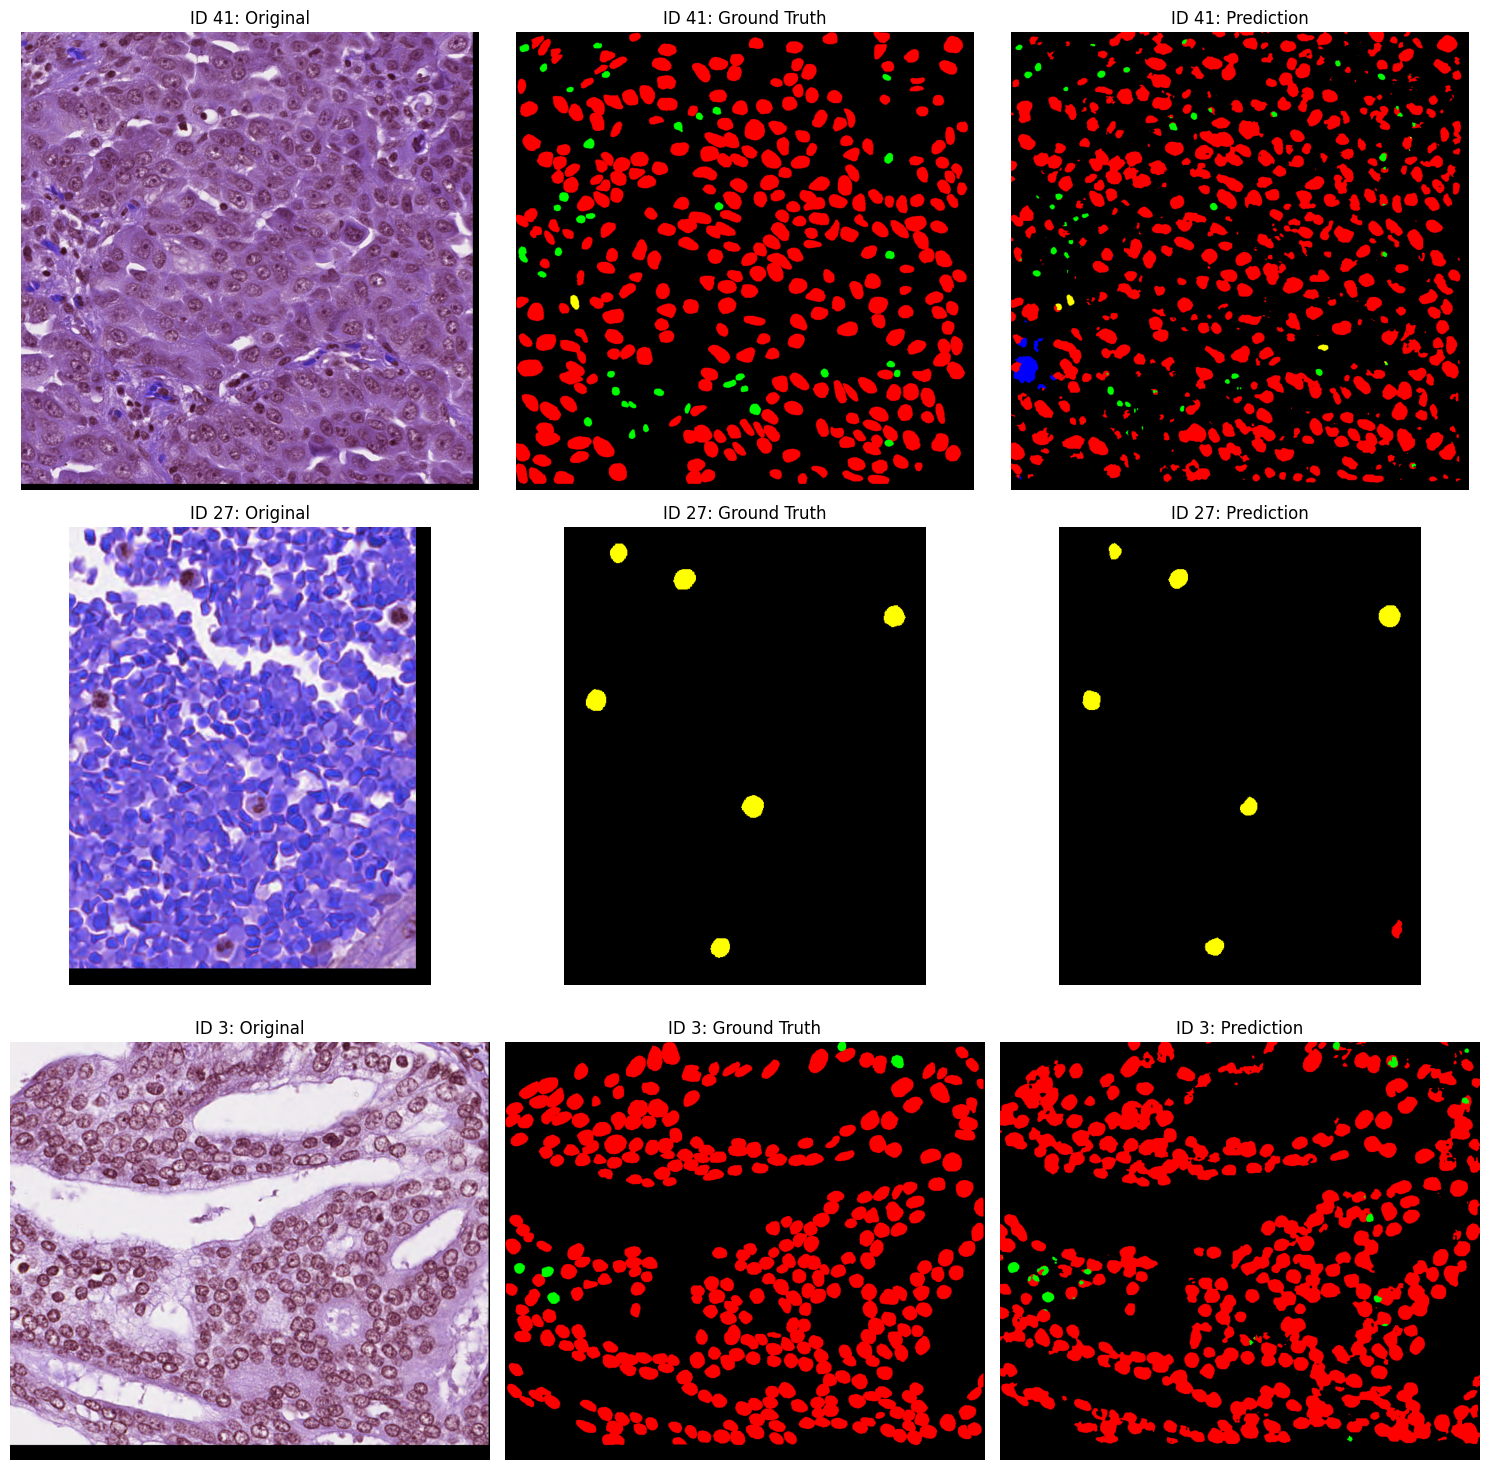

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

class_colors_map = {
    0: np.array([0, 0, 0]),       # Hintergrund: Schwarz
    1: np.array([255, 0, 0]),     # Epithelial: Rot
    2: np.array([0, 255, 0]),     # Lymphocyte: Grün
    3: np.array([0, 0, 255]),     # Macrophage: Blau
    4: np.array([255, 255, 0])    # Neutrophil: Gelb
}

def decode_mask_to_rgb(mask_2d):
    """Wandelt Index-Maske (0-4) in RGB Bild um"""
    h, w = mask_2d.shape
    rgb_image = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in class_colors_map.items():
        rgb_image[mask_2d == class_idx] = color
    return rgb_image

num_samples = 3
model.eval()

total_val_images = len(val_dataset)
# Sicherheit, falls weniger als 3 Bilder da sind
count = min(num_samples, total_val_images)
indices = random.sample(range(total_val_images), count)

print(f"Zeige zufällige Samples an den Indizes: {indices}")

plt.figure(figsize=(15, 5 * count))

for i, idx in enumerate(indices):
    # 1. Daten laden
    img_tensor, mask_tensor, filename = val_dataset[idx]
    
    # 2. Vorhersage machen
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input)
        # Argmax liefert die Klasse mit der höchsten Wahrscheinlichkeit
        prediction_tensor = torch.argmax(output, dim=1).cpu().squeeze(0)

    # 3. Umwandeln für Anzeige (Tensor -> Numpy -> RGB)
    img_display = img_tensor.permute(1, 2, 0).numpy()
    mask_display = decode_mask_to_rgb(mask_tensor.numpy())
    pred_display = decode_mask_to_rgb(prediction_tensor.numpy())

    # 4. Plotten
    # Spalte 1: Original
    plt.subplot(count, 3, i*3 + 1)
    plt.imshow(img_display)
    plt.title(f"ID {idx}: Original")
    plt.axis("off")

    # Spalte 2: Echte Maske
    plt.subplot(count, 3, i*3 + 2)
    plt.imshow(mask_display)
    plt.title(f"ID {idx}: Ground Truth")
    plt.axis("off")

    # Spalte 3: Vorhersage
    plt.subplot(count, 3, i*3 + 3)
    plt.imshow(pred_display)
    plt.title(f"ID {idx}: Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
import os
import torch
import numpy as np
import tifffile as tiff

model.eval()

# Wir erstellen ZWEI Ordner: Einen für Predictions, einen für die fertigen GT-Masken
pred_save_dir = 'predicted_masks'
gt_save_dir = 'ground_truth_masks_combined'
os.makedirs(pred_save_dir, exist_ok=True)
os.makedirs(gt_save_dir, exist_ok=True)

print("Erzeuge und speichere Predictions und Ground Truths...")

for img_tensor, mask_tensor, filename in val_dataset:
    
    # 1. Prediction machen
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_input)
        prediction_tensor = torch.argmax(output, dim=1).cpu().squeeze(0)
    
    # 2. Beide Tensoren in Numpy umwandeln (Werte 0 bis 4)
    pred_mask = prediction_tensor.numpy().astype(np.uint8)
    gt_mask = mask_tensor.numpy().astype(np.uint8) # Die Maske haben wir schon fertig!

    # 3. Pfade bauen (wir nennen beide exakt wie den filename)
    pred_path = os.path.join(pred_save_dir, filename)
    gt_path = os.path.join(gt_save_dir, filename)
    
    # 4. Speichern
    tiff.imwrite(pred_path, pred_mask)
    tiff.imwrite(gt_path, gt_mask)

print(f"Fertig! {len(val_dataset)} Vorhersagen und {len(val_dataset)} Ground-Truth-Masken gespeichert.")

Erzeuge und speichere Predictions und Ground Truths...
Fertig! 42 Vorhersagen und 42 Ground-Truth-Masken gespeichert.
